# 0. Data Loading and Libraries

In [62]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

In [61]:
# Loading data
df_train = pd.read_csv("/content/train_data.csv")
df_test = pd.read_csv("/content/test_data.csv")

<ipython-input-61-d68ed3152127>:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/content/train_data.csv")


# 1. Exploratory Analysis

## Helper functions

In [63]:
def convert_dates(df, date_columns):
    """Convert specified columns to datetime."""
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [64]:
def basic_descriptive_stats(df):
    """Display basic descriptive statistics for a DataFrame."""
    print("First 5 rows:")
    display(df.head())
    print("\nData Info:")
    display(df.info())
    print("\nNumerical Features Description:")
    display(df.describe())
    print("\nCategorical Features Description:")
    display(df.describe(include=['object', 'category']))
    print("\nMissing Values Summary:")
    print(df.isna().sum())
    print("\nDuplicate Check:")
    print(f"Number of duplicates: {df.duplicated().sum()}")


In [65]:
def feature_splitting(df, threshold=25):
    """Splits the DataFrame columns into date, categorical, high cardinality categorical, and numerical features."""
    date_features = [col for col in df.columns if 'Date' in col]
    non_metric_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    non_metric_high_cardinality = [col for col in non_metric_features if df[col].nunique() > threshold]
    metric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    print("Non-metric (Categorical) features:", non_metric_features)
    print("Non-metric (High Cardinality) features:", non_metric_high_cardinality)
    print("Metric (Numerical) features:", metric_features)

    return date_features, non_metric_features, non_metric_high_cardinality, metric_features

# Use for both train and test sets
date_features, non_metric_features, non_metric_high_cardinality, metric_features = feature_splitting(df_train)


Non-metric (Categorical) features: ['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']
Non-metric (High Cardinality) features: ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'County of Injury', 'First Hearing Date', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code']
Metric (Numerical) features: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'Industry Code', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Pa

In [66]:
def check_missing_patterns(df, columns_to_check):
    """Checks if certain variables have all their missing values in the same rows."""
    for col in columns_to_check:
        missing_rows = df[df[col].isna()][columns_to_check]
        display(missing_rows.info())


In [67]:
def num_dist(df, metric_features, bins=30):
    """Display histograms of numerical features."""
    df[metric_features].hist(bins=bins, figsize=(15, 10))
    plt.suptitle("Distribution of Numerical Variables")
    plt.show()


In [68]:
def cat_counts_and_plots(df, excl_feat=[]):
    """Display value counts and plots for categorical features, excluding high cardinality features if needed."""
    for column in df.select_dtypes(include='object').columns:
        if column not in excl_feat:
            print(f"Value counts for {column}:")
            print(df[column].value_counts())
            print("\n")

            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=column, order=df[column].value_counts().index)
            plt.title(f"Count of {column}")
            plt.xticks(rotation=90)
            plt.show()


In [69]:
def plot_bar(df, col, degrees=0):
    """Plot a bar chart for a specified column."""
    column = df[col].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column.index.astype(str), y=column.values)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=degrees)
    plt.show()

def plot_hist(df, col, rotate=False):
    """Plot a histogram for a specified column with KDE."""
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    if rotate:
        plt.xticks(rotation=45)
    plt.show()

def plot_box(df, col):
    """Plot a boxplot for a specified column."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.xlabel(col)
    plt.show()

def plot_pie(df, col):
    """Plot a pie chart for a specified column with percentage thresholds."""
    value_counts = df[col].value_counts()
    total = value_counts.sum()
    percentages = (value_counts / total) * 100

    above_threshold = percentages[percentages >= 2]
    below_threshold = percentages[percentages < 2]

    if len(below_threshold) > 0:
        other_percentage = below_threshold.sum()
        above_threshold['Others'] = other_percentage

    plt.figure(figsize=(8, 8))
    above_threshold.plot.pie(autopct='%1.1f%%', startangle=90, labels=above_threshold.index)
    plt.ylabel("")
    plt.xlabel(col)
    plt.legend(title="Legend", loc='upper left')
    plt.show()

def plot_heatmap(df, numerical_features):
    """Display heatmap of correlation among numerical features."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=df[numerical_features].corr(method='spearman'), annot=True, cmap="coolwarm", fmt='.1f')
    plt.show()


In [124]:
def detect_outliers_in_column(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [173]:
# NEW
def cast_code_columns(df, code_identifiers=['Code']):
    """
    Cast columns with names containing keywords (e.g., 'Code') to categorical data type, ignoring case.

    Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        code_identifiers (list): List of keywords to identify code columns. Default is ['Code'].

    Returns:
        pd.DataFrame: The modified DataFrame with code columns cast to categorical.
    """
    # Convert code_identifiers to lowercase for case-insensitive matching
    code_identifiers = [keyword.lower() for keyword in code_identifiers]

    # Loop through columns to find those that match code identifiers, case-insensitively
    for col in df.columns:
        if any(keyword in col.lower() for keyword in code_identifiers):
            # Check if the column is currently numeric, then cast to category
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].astype('category')
                print(f"Column '{col}' cast to 'category' data type.")
            else:
                print(f"Column '{col}' already non-numeric, no casting applied.")

    return df

In [70]:
# Define date columns
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
convert_dates(df_train, date_columns)
convert_dates(df_test, date_columns)

In [174]:
df_train = cast_code_columns(df_train)
df_test = cast_code_columns(df_test)

Column 'Industry Code' cast to 'category' data type.
Column 'Industry Code Description' already non-numeric, no casting applied.
Column 'WCIO Cause of Injury Code' cast to 'category' data type.
Column 'WCIO Nature of Injury Code' cast to 'category' data type.
Column 'WCIO Part Of Body Code' cast to 'category' data type.
Column 'Zip Code' already non-numeric, no casting applied.
Column 'Industry Code' cast to 'category' data type.
Column 'Industry Code Description' already non-numeric, no casting applied.
Column 'WCIO Cause of Injury Code' cast to 'category' data type.
Column 'WCIO Nature of Injury Code' cast to 'category' data type.
Column 'WCIO Part Of Body Code' cast to 'category' data type.
Column 'Zip Code' already non-numeric, no casting applied.


## Step 1: General descr. stats

In [71]:
basic_descriptive_stats(df_train)

First 5 rows:


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaT,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaT,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaT,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaT,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64       
 2   Alternative Dispute Resolution      574026 non-null  object        
 3   Assembly Date                       593471 non-null  datetime64[ns]
 4   Attorney/Representative             574026 non-null  object        
 5   Average Weekly Wage                 545375 non-null  float64       
 6   Birth Year                          544948 non-null  float64       
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 9   Carrier Name                        574026 non-null  object        
 

None


Numerical Features Description:


,Accident Date,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Claim Identifier,First Hearing Date,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,570337,574026.000000,593471,5.453750e+05,544948.000000,559466,187245,5.934710e+05,150798,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,2021-04-28 21:00:27.892982784,42.114270,2021-07-19 03:25:38.260841728,4.910883e+02,1886.767604,2021-07-16 20:11:19.865443328,2021-07-26 21:31:28.449891840,2.366760e+07,2022-03-19 05:07:38.218278400,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,0.046665,3.006559
min,1961-09-06 00:00:00,0.000000,2020-01-01 00:00:00,0.000000e+00,0.000000,1996-01-12 00:00:00,1992-11-13 00:00:00,5.393066e+06,2020-01-30 00:00:00,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,2020-09-14 00:00:00,31.000000,2020-10-26 00:00:00,0.000000e+00,1965.000000,2020-11-06 00:00:00,2020-10-27 00:00:00,5.593414e+06,2021-06-01 00:00:00,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,0.000000,1.000000
50%,2021-06-27 00:00:00,42.000000,2021-07-29 00:00:00,0.000000e+00,1977.000000,2021-08-09 00:00:00,2021-07-21 00:00:00,5.791212e+06,2022-03-09 00:00:00,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,0.000000,3.000000
75%,2022-03-21 00:00:00,54.000000,2022-04-19 00:00:00,8.410000e+02,1989.000000,2022-04-26 00:00:00,2022-04-20 00:00:00,5.991000e+06,2023-01-11 00:00:00,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,0.000000,5.000000
max,2023-09-29 00:00:00,117.000000,2022-12-31 00:00:00,2.828079e+06,2018.000000,2024-06-01 00:00:00,2024-05-31 00:00:00,9.998917e+08,2024-06-07 00:00:00,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,1.000000,6.000000
std,NaN,14.256432,NaN,6.092918e+03,414.644423,NaN,NaN,1.079271e+08,NaN,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,0.210921,2.000801



Categorical Features Description:


,Alternative Dispute Resolution,Attorney/Representative,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,574026,574026,574026,574026,574026,574026,574026,574026,574026,564068,574026,558386,558369,556944,545389,574026
unique,3,2,2046,8,8,63,2,8,4,20,5,74,56,54,10060,1
top,N,N,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,571412,392291,111144,285368,291078,60430,546505,270779,335218,114339,265981,46610,153373,51862,3302,574026



Missing Values Summary:
Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19445
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region            

## Step 2: Single Feature analysis

### Acident date variable

First, we need to ensure that this variable is in the correct date format.

In [72]:
df_train['Accident Date'] = pd.to_datetime(df_train['Accident Date'])

Let's examine the key statistics for this variable:

In [119]:
df_train['Accident Date'].describe()

,Accident Date
count,570332
mean,2021-04-28 20:59:18.718781440
min,1961-09-06 00:00:00
25%,2020-09-14 00:00:00
50%,2021-06-27 00:00:00
75%,2022-03-21 00:00:00
max,2023-09-29 00:00:00


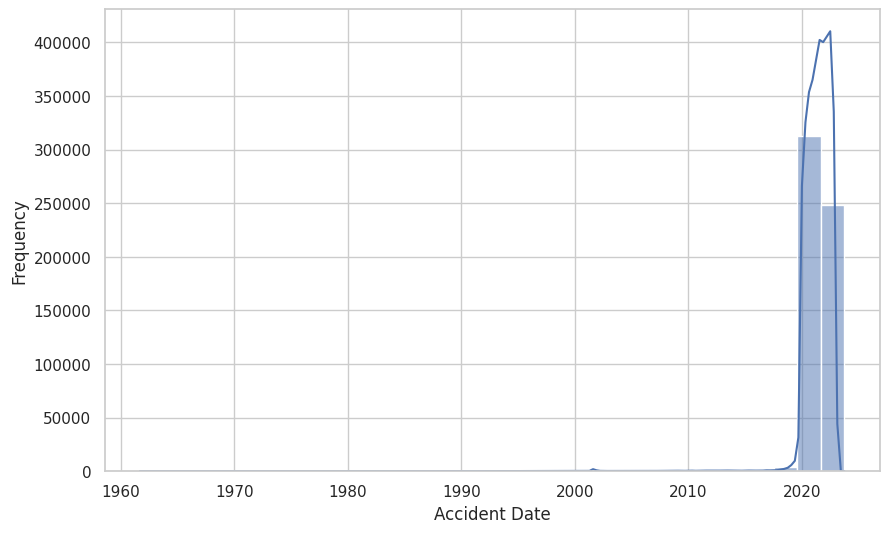

In [120]:
plot_hist(df_train, 'Accident Date')

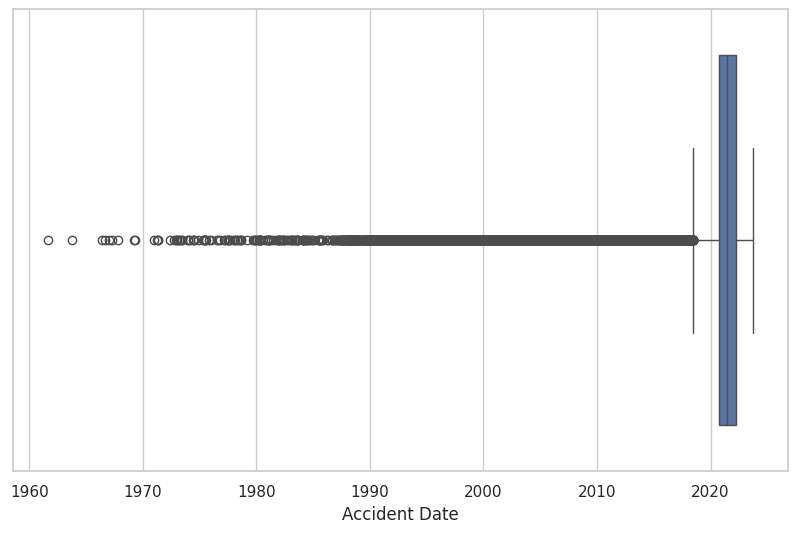

In [121]:
plot_box(df_train, 'Accident Date')

We can see by the histogram, that this variable is very assimetric probably due to having a big number of outliers as we can see in the boxplot. To get better visualisations we will omit this outliers in some visualisations

Now we will analyze the situation regarding the missing values:

In [122]:
print('The Accident Date variable has ' + str(df_train['Accident Date'].isna().mean()*100) + '% of missing values')
print('The Accident Date variable has ' + str(df_test['Accident Date'].isna().mean()*100) + '% of missing values')

The Accident Date variable has 3.8981171625670212% of missing values
The Accident Date variable has 0.6299391196317279% of missing values


In [125]:
detect_outliers_in_column(df_train, 'Accident Date')['Accident Date'].max()

Timestamp('2018-06-07 00:00:00')

Let`s extract some adicional date-related columns

In [126]:
df_train['Accident Year'] = df_train['Accident Date'].dt.year
df_train['Accident Month'] = df_train['Accident Date'].dt.month
df_train['Accident DayOfWeek'] = df_train['Accident Date'].dt.dayofweek

This next bar plot show us the number of accidents by day of th week:

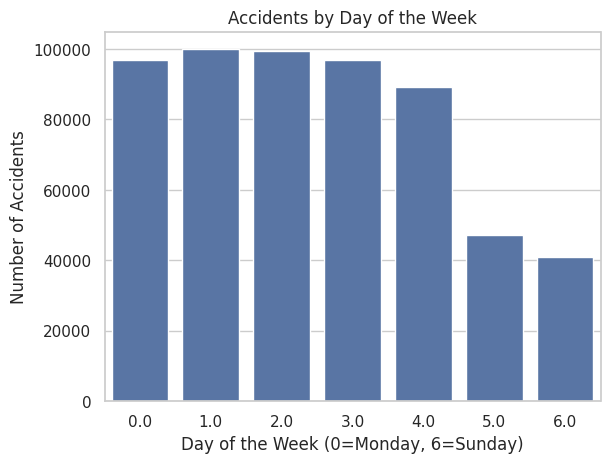

In [127]:
dayofweek_accidents = df_train['Accident DayOfWeek'].value_counts().sort_index()
sns.barplot(x=dayofweek_accidents.index, y=dayofweek_accidents.values)
plt.title("Accidents by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Accidents")
plt.show()

This plot shows that workplace accidents occur more frequently during weekdays, likely because most people work Monday through Friday, resulting in fewer incidents over the weekend when fewer people are on-site

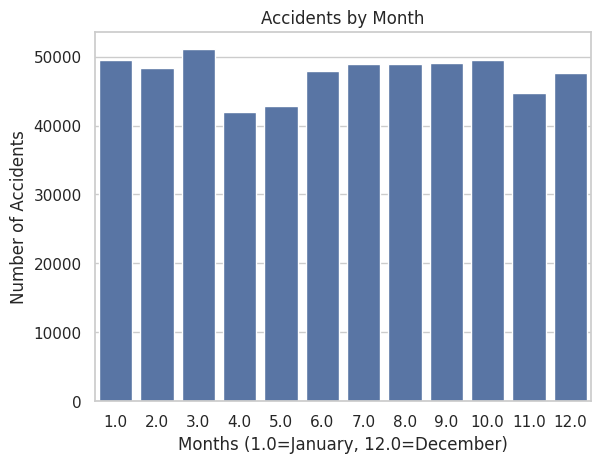

In [128]:
dayofweek_accidents = df_train['Accident Month'].value_counts().sort_index()
sns.barplot(x=dayofweek_accidents.index, y=dayofweek_accidents.values)
plt.title("Accidents by Month")
plt.xlabel("Months (1.0=January, 12.0=December)")
plt.ylabel("Number of Accidents")
plt.show()

From the graph, we notice a decrease in workplace accidents in April and May. What could explain this trend?

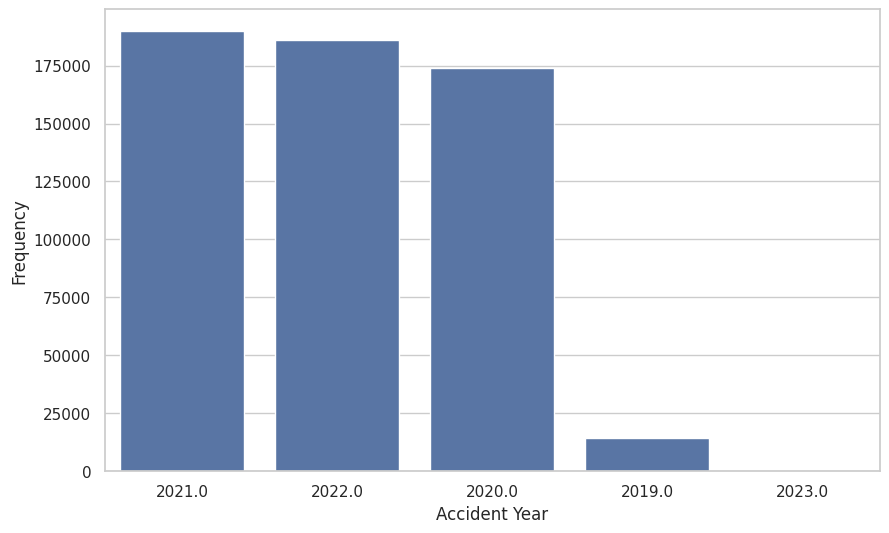

In [129]:
plot_bar(df_train[df_train['Accident Year']>2018], 'Accident Year')

### Assembly date variable

First, we need to ensure that this variable is in the correct date format.

In [137]:
df_train['Assembly Date'] = pd.to_datetime(df_train['Assembly Date'])

Let's examine the key statistics for this variable:

In [138]:
df_train['Assembly Date'].describe()

,Assembly Date
count,567719
mean,2021-07-20 06:51:20.626859520
min,2020-01-01 00:00:00
25%,2020-10-27 00:00:00
50%,2021-08-02 00:00:00
75%,2022-04-20 00:00:00
max,2022-12-31 00:00:00


In [139]:
print('The Assembly Date variable has ' + str(df_train['Assembly Date'].isna().mean()*100) + '% of missing values in the train data')
print('The Assembly Date variable has ' + str(df_test['Assembly Date'].isna().mean()*100) + '% of missing values in the test data')

The Assembly Date variable has 0.0% of missing values in the train data
The Assembly Date variable has 0.0% of missing values in the test data


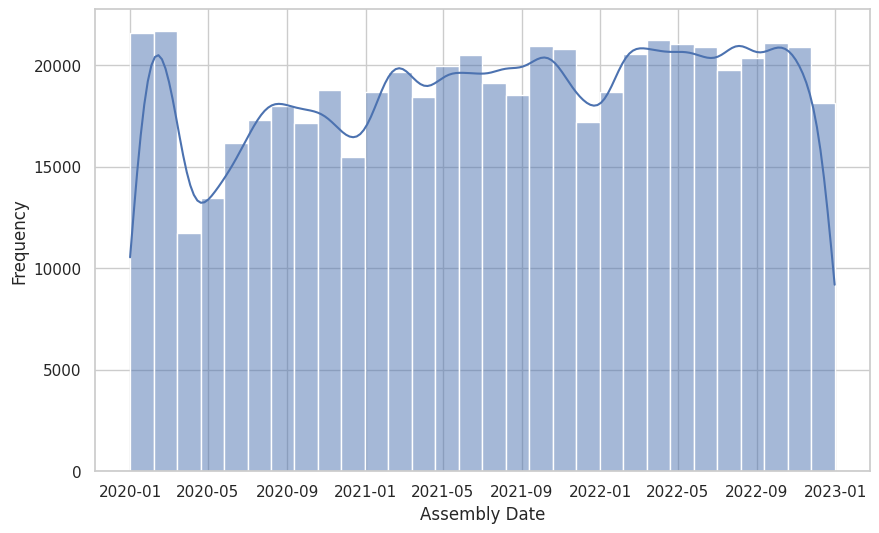

In [140]:
plot_hist(df_train, 'Assembly Date')

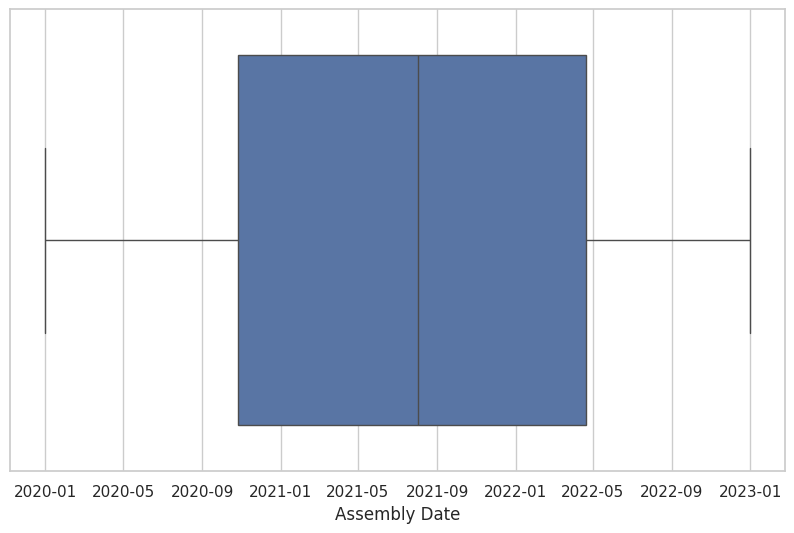

In [141]:
plot_box(df_train, 'Assembly Date')

From this table, we see that the first assembly date in this dataframe occurred on 2020-01-01 and the last one on 2022-12-31.

### C-2 Date variable

First, we need to ensure that this variable is in the correct date format.

In [142]:
df_train['C-2 Date'] = pd.to_datetime(df_train['C-2 Date'])
df_test['C-2 Date'] = pd.to_datetime(df_test['C-2 Date'])

Let's examine the key statistics for this variable:

In [143]:
df_train['C-2 Date'].describe()

,C-2 Date
count,555555
mean,2021-07-16 22:31:25.409725184
min,1996-01-12 00:00:00
25%,2020-11-06 00:00:00
50%,2021-08-09 00:00:00
75%,2022-04-26 00:00:00
max,2024-06-01 00:00:00


In [144]:
print('The C-2 Date variable has ' + str(df_train['C-2 Date'].isna().mean()*100) + '% of missing values in the train data')
print('The C-2 Date variable has ' + str(df_test['C-2 Date'].isna().mean()*100) + '% of missing values in the test data')

The C-2 Date variable has 2.142609283818227% of missing values in the train data
The C-2 Date variable has 2.1173656813243498% of missing values in the test data


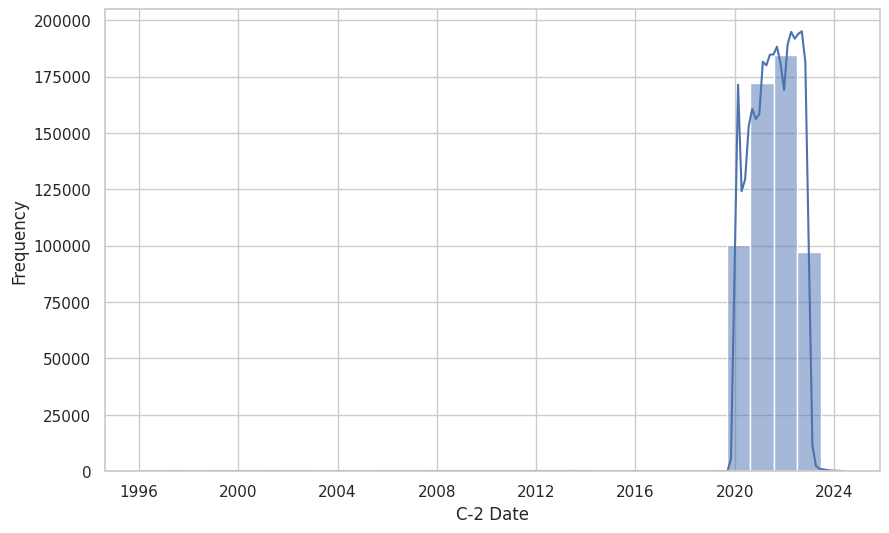

In [145]:
plot_hist(df_train, 'C-2 Date')

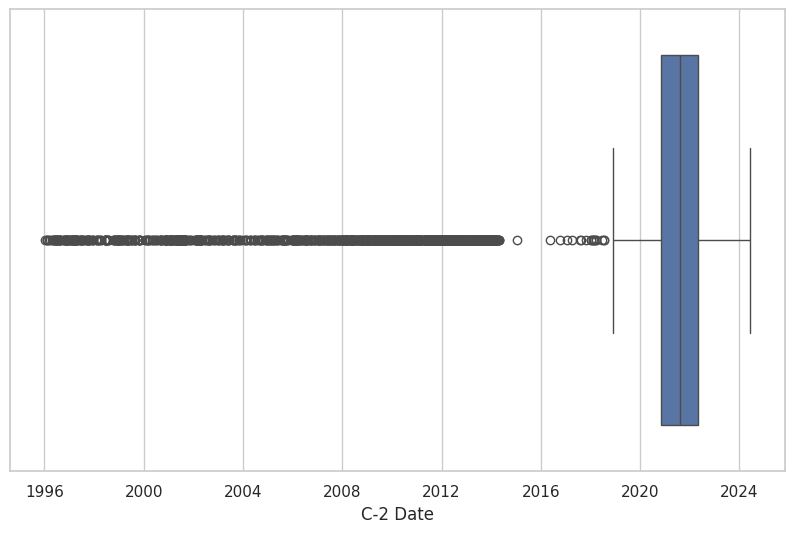

In [146]:
plot_box(df_train, 'C-2 Date')

### C-3 Date variable

First, we need to ensure that this variable is in the correct date format.

In [147]:
df_train['C-3 Date'] = pd.to_datetime(df_train['C-3 Date'])
df_test['C-3 Date'] = pd.to_datetime(df_test['C-3 Date'])

Let's examine the key statistics for this variable:

In [148]:
df_train['C-3 Date'].describe()

,C-3 Date
count,183293
mean,2021-07-28 10:37:08.628480768
min,2010-07-29 00:00:00
25%,2020-10-28 00:00:00
50%,2021-07-22 00:00:00
75%,2022-04-20 00:00:00
max,2024-05-31 00:00:00


In [149]:
print('The C-3 Date variable has ' + str(df_train['C-3 Date'].isna().mean()*100) + '% of missing values in the train data')
print('The C-3 Date variable has ' + str(df_test['C-3 Date'].isna().mean()*100) + '% of missing values in the test data')

The C-3 Date variable has 67.71413322435923% of missing values in the train data
The C-3 Date variable has 78.44622302814295% of missing values in the test data


This variable is highly composed of missing values, so we will probably exclude her

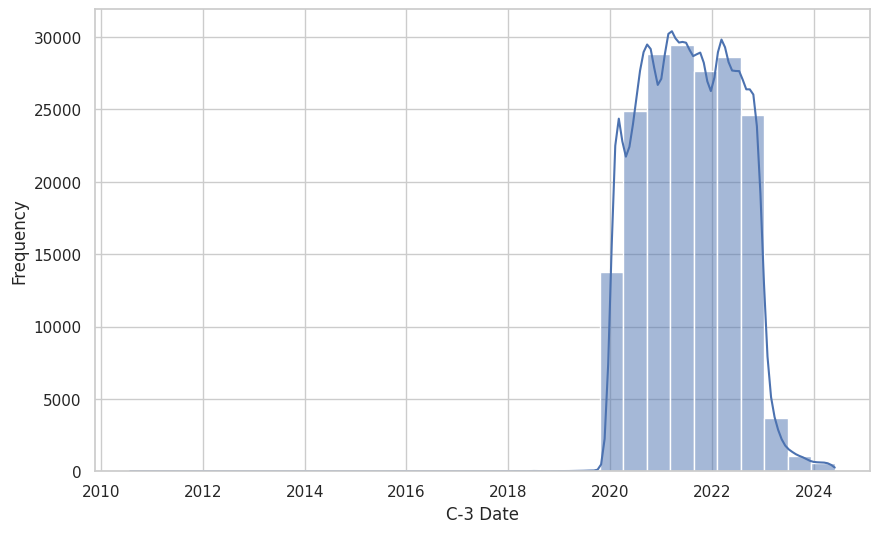

In [150]:
plot_hist(df_train, 'C-3 Date')

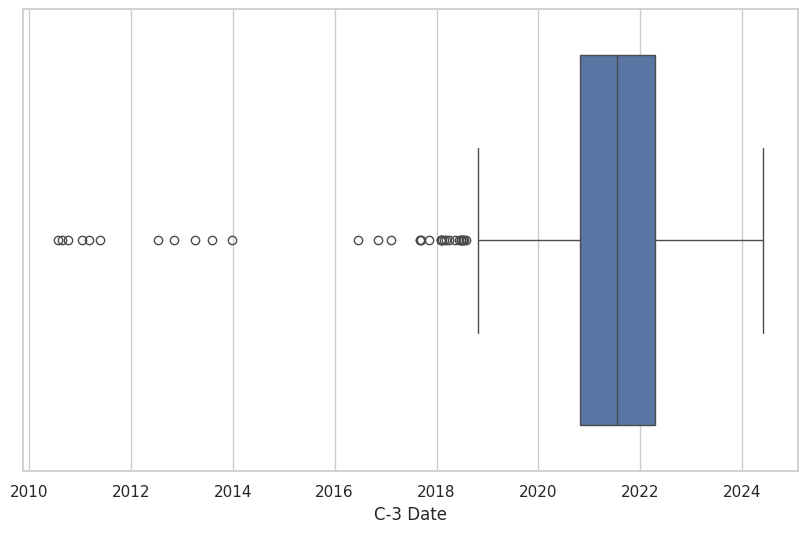

In [151]:
plot_box(df_train, 'C-3 Date')

### First Hearing Date variable

First, we need to ensure that this variable is in the correct date format.

In [152]:
df_train['First Hearing Date'] = pd.to_datetime(df_train['First Hearing Date'])
df_test['First Hearing Date'] = pd.to_datetime(df_test['First Hearing Date'])

Let's examine the key statistics for this variable:

In [153]:
df_train['First Hearing Date'].describe()

,First Hearing Date
count,148951
mean,2022-03-20 05:29:29.486609152
min,2020-01-30 00:00:00
25%,2021-06-02 00:00:00
50%,2022-03-10 00:00:00
75%,2023-01-11 00:00:00
max,2024-06-07 00:00:00


In [154]:
print('The First Hearing Date variable has ' + str(df_train['First Hearing Date'].isna().mean()*100) + '% of missing values in the train data')
print('The First Hearing Date has ' + str(df_test['First Hearing Date'].isna().mean()*100) + '% of missing values in the test data')

The First Hearing Date variable has 73.76325259503382% of missing values in the train data
The First Hearing Date has 89.03044608755009% of missing values in the test data


This variable is highly composed of missing values, so we will probably exclude her

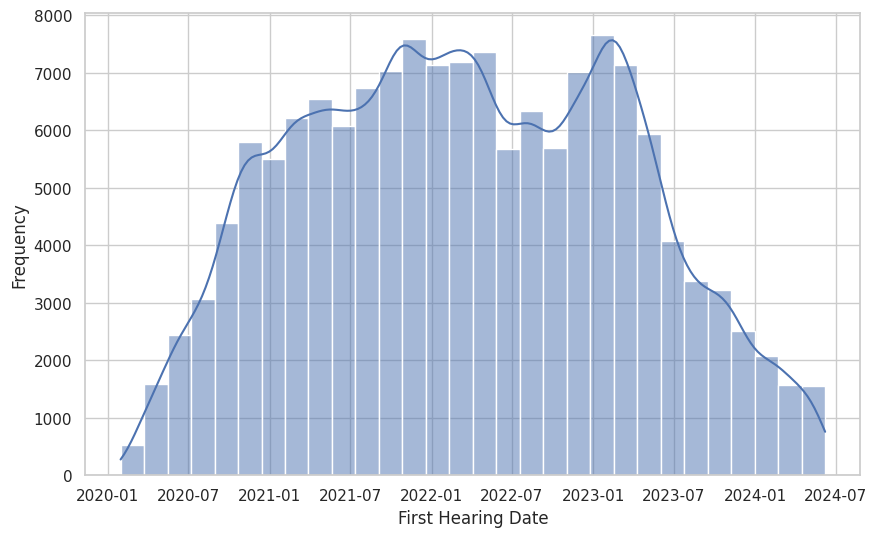

In [155]:
plot_hist(df_train, 'First Hearing Date')

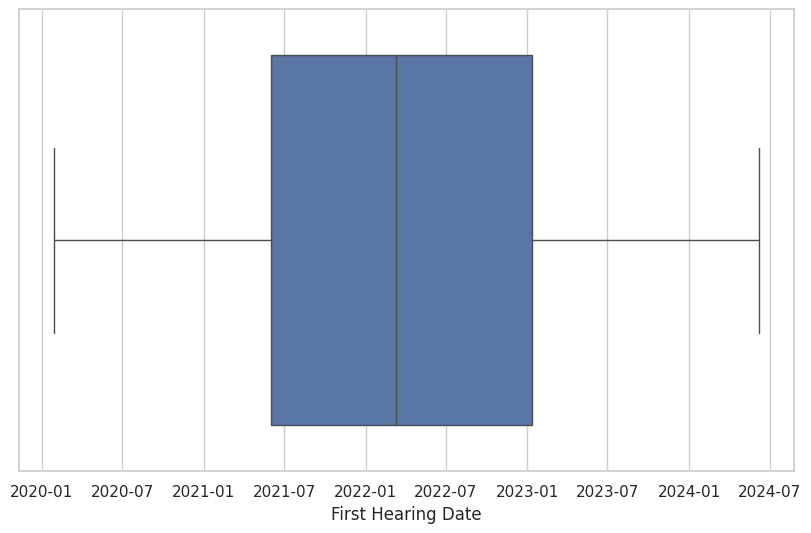

In [156]:
plot_box(df_train, 'First Hearing Date')

### Age at injury variable

Let's examine the key statistics for this variable:

In [130]:
df_train['Age at Injury'].describe()

,Age at Injury
count,574021.000000
mean,42.114154
std,14.256439
min,0.000000
25%,31.000000
50%,42.000000
75%,54.000000
max,117.000000


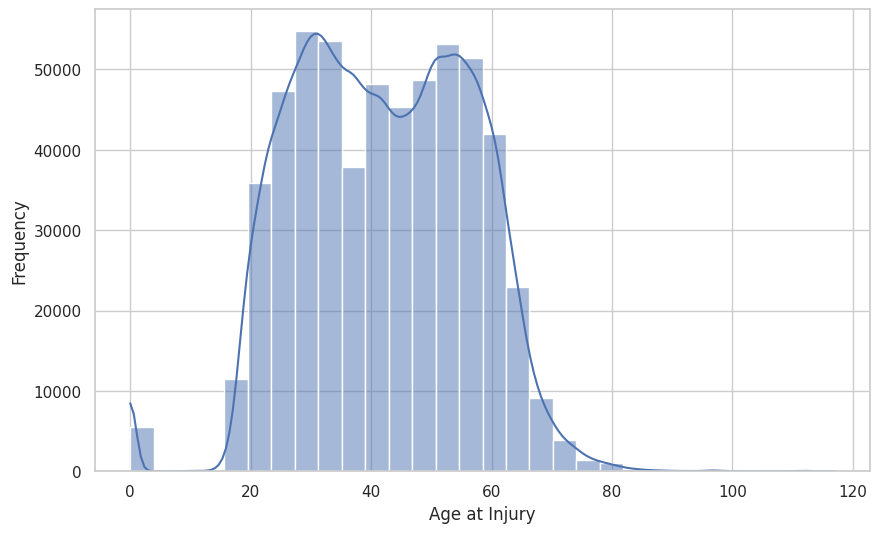

In [131]:
plot_hist(df_train, 'Age at Injury')

In [132]:
print(df_train[df_train['Age at Injury']==0]['Age at Injury'].count())
print(df_test[df_test['Age at Injury']==0]['Age at Injury'].count())

5464
3248


There is in this variable at the two dataframes null values, we will fill them with NAN values because they are probably due to some data coleting problem.

In [133]:
df_train['Age at Injury'] = df_train['Age at Injury'].replace(0, np.nan)
df_test['Age at Injury'] = df_test['Age at Injury'].replace(0, np.nan)

Another issue is the presence of incorrect values in this variable. Specifically, ages below 14 are invalid, as the minimum working age in the U.S. is 14 years. Additionally, ages exceeding 80 are also considered erroneous.

In [134]:
print(df_train[(df_train['Age at Injury'] < 14) | (df_train['Age at Injury'] > 80)]['Age at Injury'].count())
print(df_test[(df_test['Age at Injury'] < 14) | (df_test['Age at Injury'] > 80)]['Age at Injury'].count())

838
900


As there is a small number of rows with these problem, we will just eliminate them

In [135]:
df_train = df_train[(df_train['Age at Injury'] >= 14) & (df_train['Age at Injury'] <= 80)]
df_test = df_test[(df_test['Age at Injury'] >= 14) & (df_test['Age at Injury'] <= 80)]

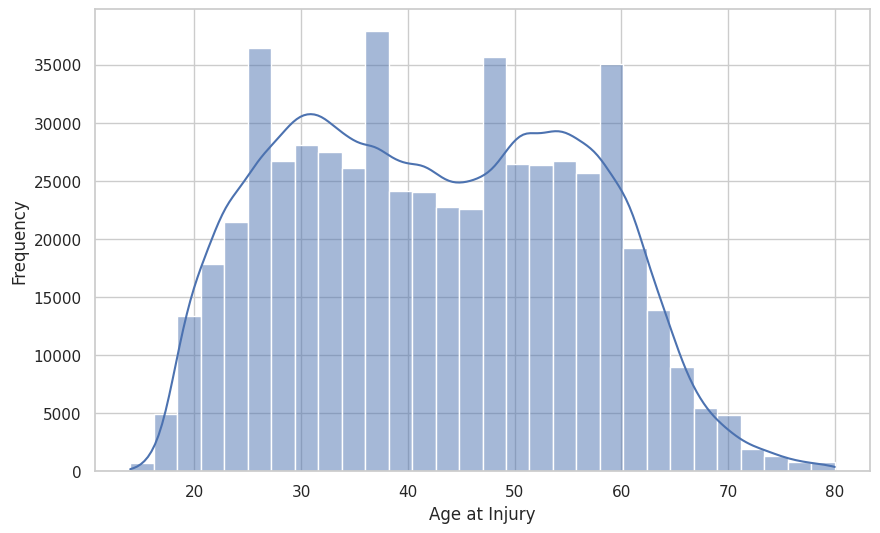

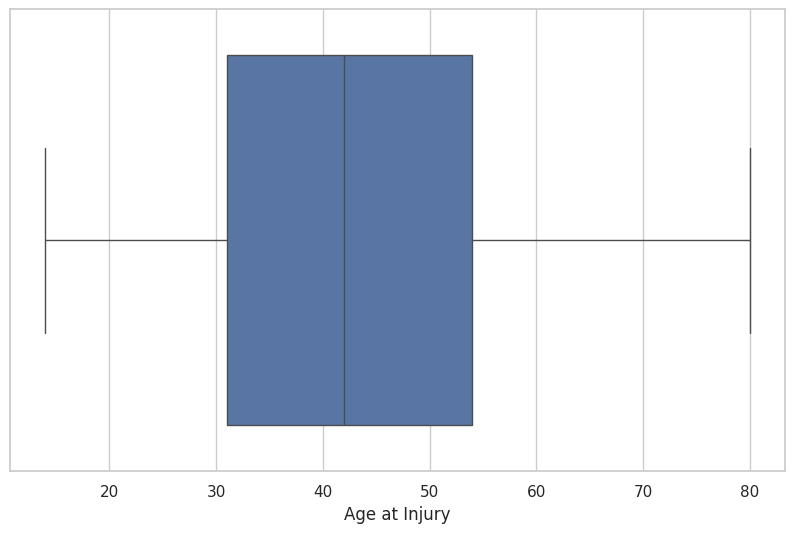

In [136]:
plot_hist(df_train, 'Age at Injury')
plot_box(df_train, 'Age at Injury')

### Birth Year variable

In [157]:
df_train['Birth Year'].describe()

,Birth Year
count,538943.000000
mean,1893.150264
std,400.853194
min,0.000000
25%,1965.000000
50%,1977.000000
75%,1989.000000
max,2008.000000


There are Birth years with a value of 0, this is clearly an error so we will replace it with a missing value

In [158]:
df_train[df_train['Birth Year']==0]['Birth Year'].count()

23101

In [159]:
df_train['Birth Year'] = df_train['Birth Year'].replace(0, np.nan)
df_test['Birth Year'] = df_test['Birth Year'].replace(0, np.nan)

In [161]:
(df_train['Birth Year'].isna().mean())*100

9.137795282525333

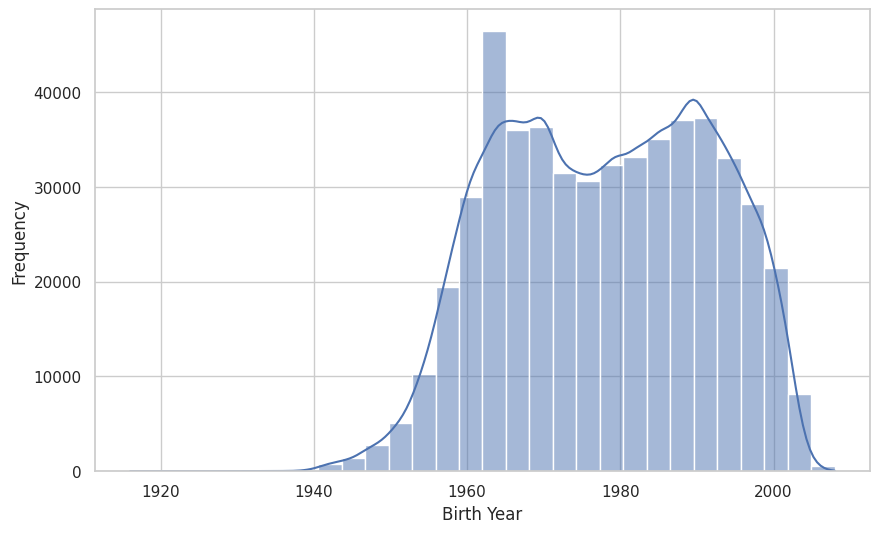

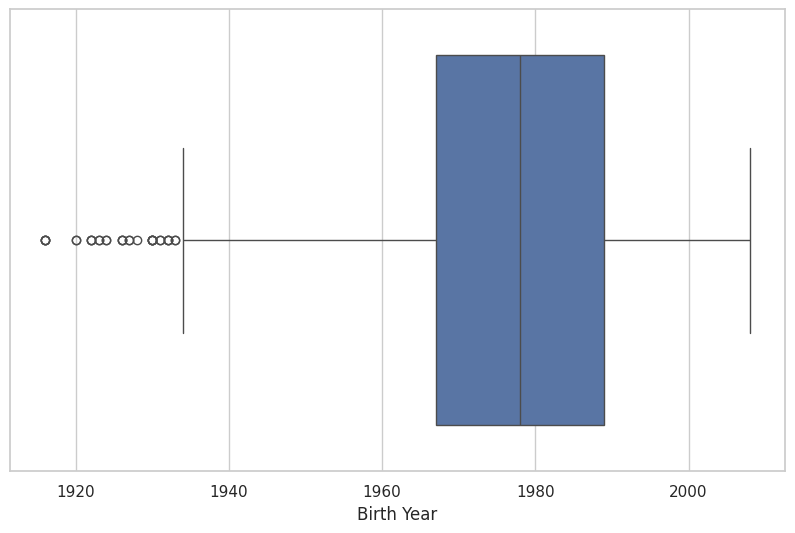

In [163]:
plot_hist(df_train, 'Birth Year')
plot_box(df_train, 'Birth Year')

### Carrier Type variable

Let's examine the key statistics for this variable:

In [164]:
df_train['Carrier Type'].describe()

,Carrier Type
count,567719
unique,8
top,1A. PRIVATE
freq,282125


In [165]:
df_train['Carrier Type'].value_counts()

,count
Carrier Type,
1A. PRIVATE,282125
3A. SELF PUBLIC,120421
2A. SIF,110262
4A. SELF PRIVATE,52318
UNKNOWN,1623
5D. SPECIAL FUND - UNKNOWN,964
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A),3
5C. SPECIAL FUND - POI CARRIER WCB MENANDS,3


In [166]:
df_train['Carrier Type'].isna().sum()

0

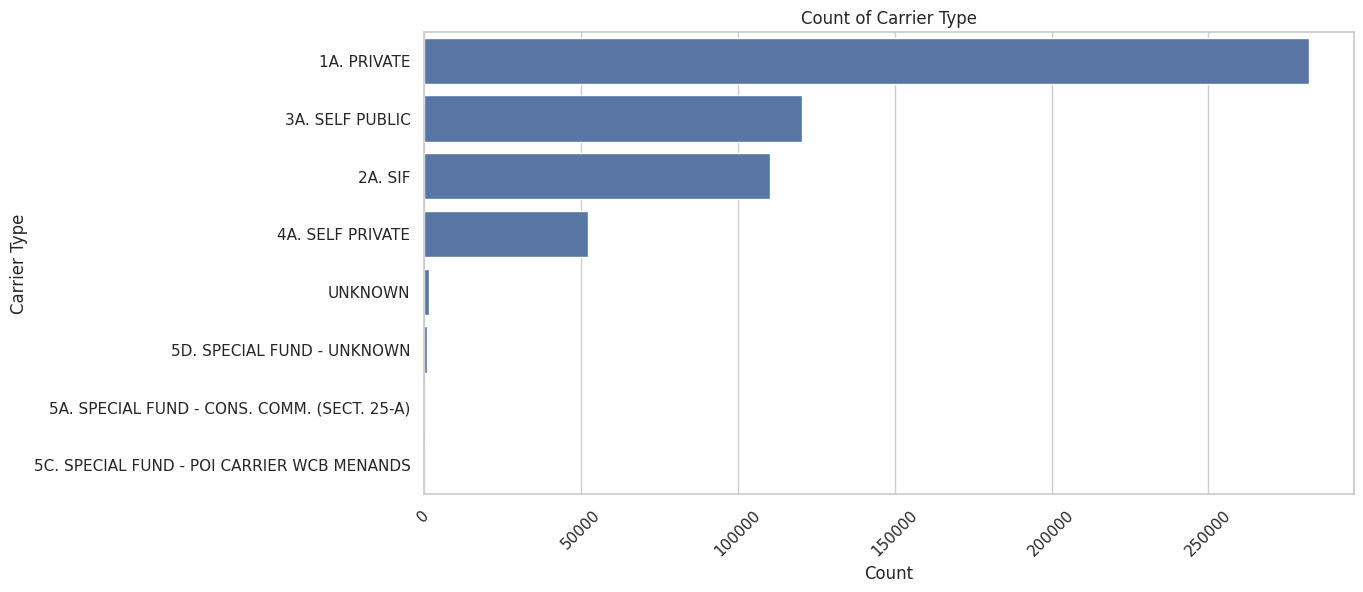

In [167]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a count plot for 'District Name'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='Carrier Type', order=df_train['Carrier Type'].value_counts().index)
plt.title('Count of Carrier Type')
plt.xlabel('Count')
plt.ylabel('Carrier Type')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

### County of Injury variable

In [168]:
df_train['County of Injury'].describe()

,County of Injury
count,567719
unique,63
top,SUFFOLK
freq,59704


In [170]:
df_train['County of Injury'].value_counts()

,count
County of Injury,
SUFFOLK,59704
QUEENS,57623
KINGS,52565
NASSAU,43074
BRONX,39206
...,...
WYOMING,754
MONTGOMERY,609
SCHOHARIE,554


In [171]:
df_train['County of Injury'].isna().sum()

0

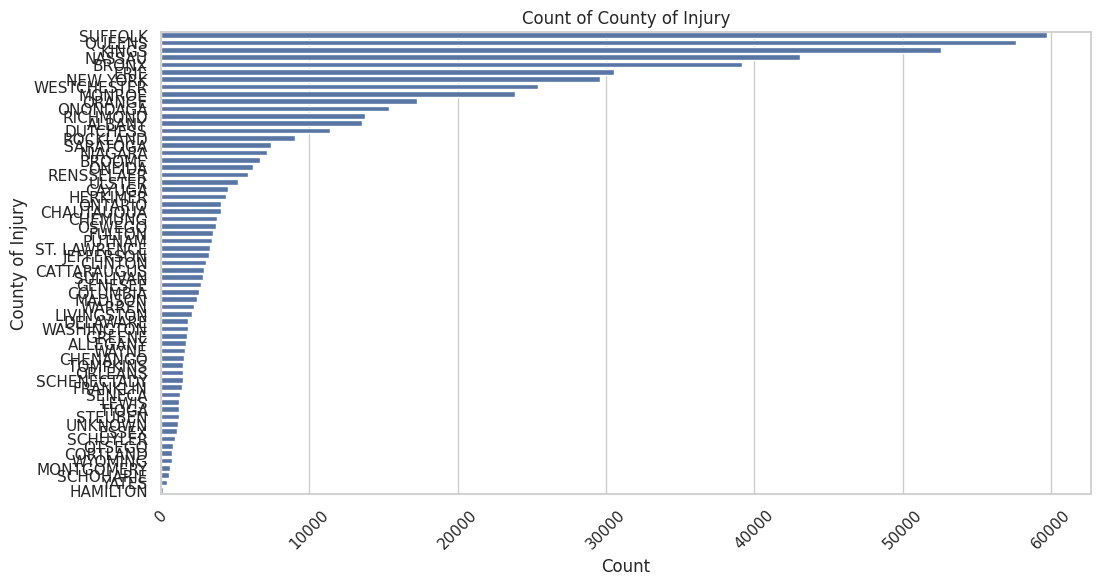

In [172]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a count plot for 'District Name'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='County of Injury', order=df_train['County of Injury'].value_counts().index)
plt.title('Count of County of Injury')
plt.xlabel('Count')
plt.ylabel('County of Injury')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

### Attorney Representation variable

In [73]:
df_train['Attorney/Representative'].describe()

,Attorney/Representative
count,574026
unique,2
top,N
freq,392291


In [74]:
df_train['Attorney/Representative'].value_counts()

,count
Attorney/Representative,
N,392291
Y,181735


In [75]:
# Replace 'Y' with True, 'N' with False, and preserve NaNs
df_train['Attorney/Representative'] = df_train['Attorney/Representative'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_train['Attorney/Representative'] = df_train['Attorney/Representative'].astype("boolean")

In [76]:
# Replace 'Y' with True, 'N' with False, and preserve NaNs
df_test['Attorney/Representative'] = df_test['Attorney/Representative'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_test['Attorney/Representative'] = df_test['Attorney/Representative'].astype("boolean")

<ipython-input-76-1594995a33a5>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Attorney/Representative'] = df_test['Attorney/Representative'].replace({'Y': True, 'N': False})


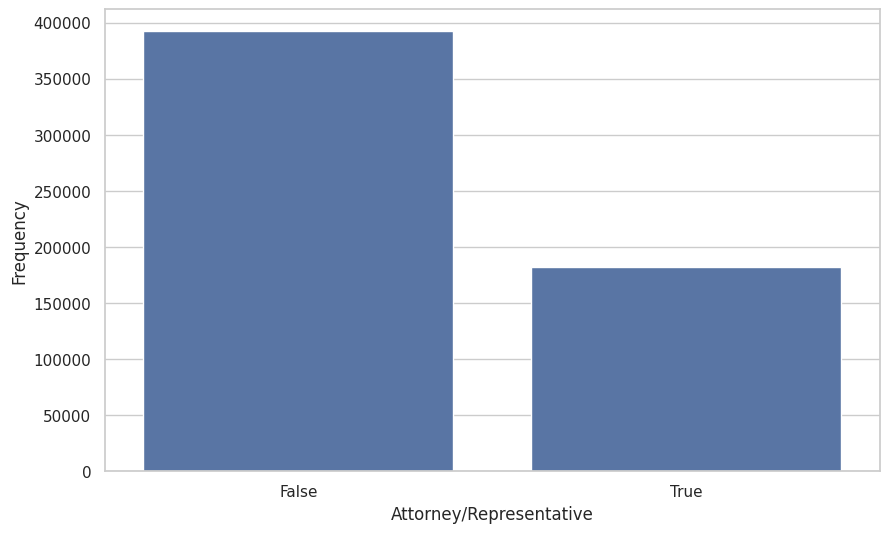

In [77]:
plot_bar(df_train, 'Attorney/Representative')

### Alternative Dispute Resolution variable

In [78]:
df_train['Alternative Dispute Resolution'].value_counts()

,count
Alternative Dispute Resolution,
N,571412
Y,2609
U,5


The 5 cases recorded with 'U' should be an error. They are likely meant to be 'Y', since the Y and U keys are located next to each other. In fact, the 'Alternative Dispute Resolution' variable should be a boolean. Since 5 cases represent a minority in the data and contain errors, we can safely remove these rows.

In [79]:
df_train = df_train.drop(df_train[df_train['Alternative Dispute Resolution'] == 'U'].index)
df_train['Alternative Dispute Resolution'] = df_train['Alternative Dispute Resolution'].replace({'Y': True, 'N': False})
df_train['Alternative Dispute Resolution'] = df_train['Alternative Dispute Resolution'].astype("boolean")

In [80]:
df_test= df_test.drop(df_test[df_test['Alternative Dispute Resolution'] == 'U'].index)
df_test['Alternative Dispute Resolution'] = df_test['Alternative Dispute Resolution'].replace({'Y': True, 'N': False})
df_test['Alternative Dispute Resolution'] = df_test['Alternative Dispute Resolution'].astype("boolean")

<ipython-input-80-c25953457653>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Alternative Dispute Resolution'] = df_test['Alternative Dispute Resolution'].replace({'Y': True, 'N': False})


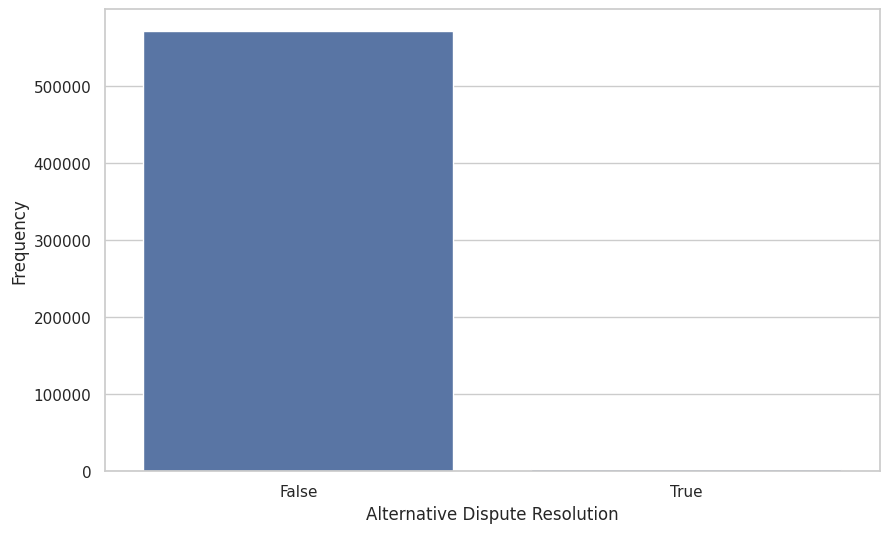

In [81]:
plot_bar(df_train, 'Alternative Dispute Resolution')

### Carrier Name variable

In [82]:
df_train['Carrier Name'].describe()

,Carrier Name
count,574021
unique,2046
top,STATE INSURANCE FUND
freq,111144


In [83]:
df_train['Carrier Name'].isna().sum()

19445

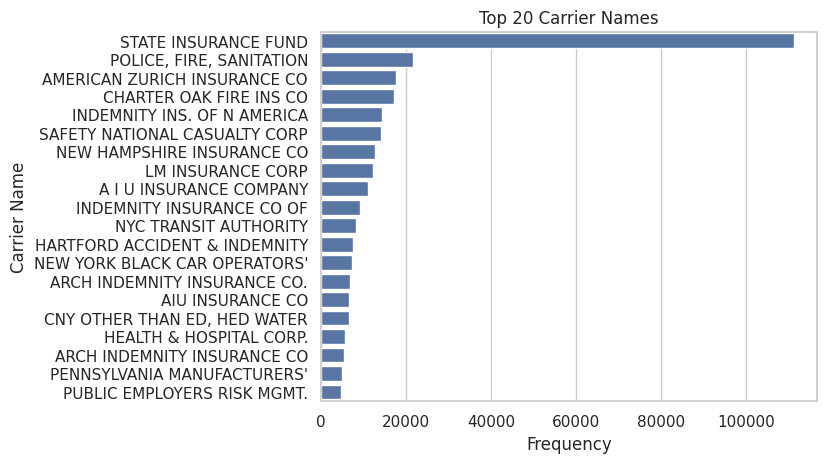

In [84]:
top_carriers = df_train['Carrier Name'].value_counts().nlargest(20)
sns.barplot(x=top_carriers.values, y=top_carriers.index)
plt.title('Top 20 Carrier Names')
plt.xlabel('Frequency')
plt.ylabel('Carrier Name')
plt.show()

### Claim Identifier variable

In [85]:
df_train['Claim Identifier'].describe()

,Claim Identifier
count,5.934660e+05
mean,2.366775e+07
std,1.079276e+08
min,5.393066e+06
25%,5.593414e+06
50%,5.791210e+06
75%,5.990995e+06
max,9.998917e+08


In [86]:
df_train['Claim Identifier'].nunique()

593465

In [87]:
df_train['Claim Identifier'].size

593466

In [88]:
df_train['Claim Identifier'].isna().sum()

0

### District Name variable

In [89]:
df_train['District Name'] = df_train['District Name'].astype('category')
df_test['District Name'] = df_test['District Name'].astype('category')

In [90]:
df_train['District Name'].describe()

,District Name
count,574021
unique,8
top,NYC
freq,270776


In [91]:
df_train['District Name'].isna().sum()

19445

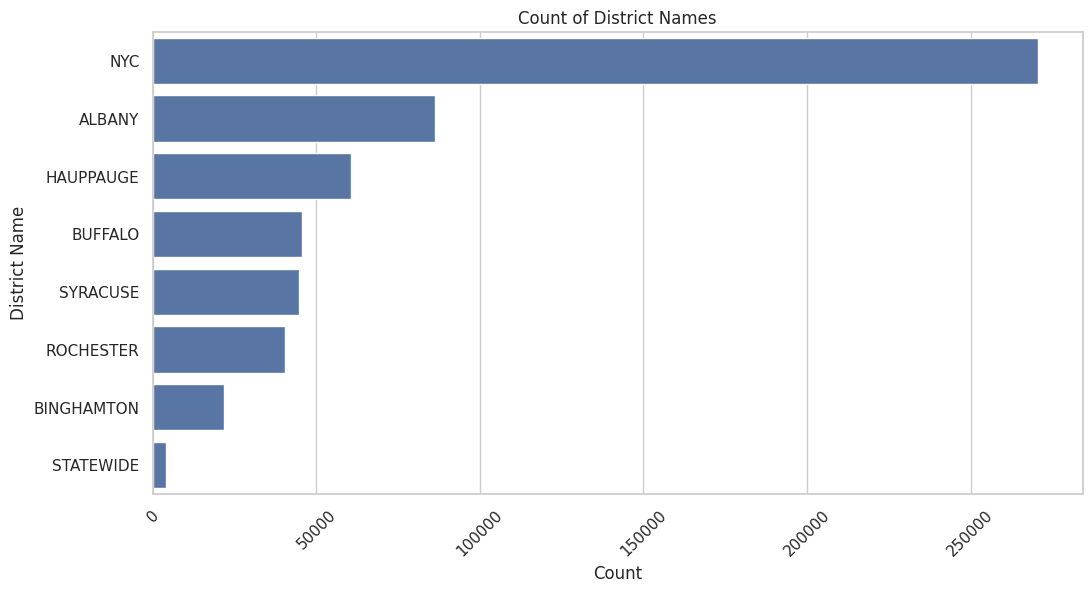

In [92]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a count plot for 'District Name'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='District Name', order=df_train['District Name'].value_counts().index)
plt.title('Count of District Names')
plt.xlabel('Count')
plt.ylabel('District Name')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

### IME-4 Count variable

In [93]:
df_train['IME-4 Count'].describe()

,IME-4 Count
count,132802.000000
mean,3.207354
std,2.832308
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,73.000000


In [94]:
(df_train['IME-4 Count'].isna().mean())*100

77.62264392568403

With ~78% of the IME-4 Count column values missing maybe does not make sense to retain the column in our analysis.


But let's analyse it anyway


Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner's Report of Independent Medical Examination” form.

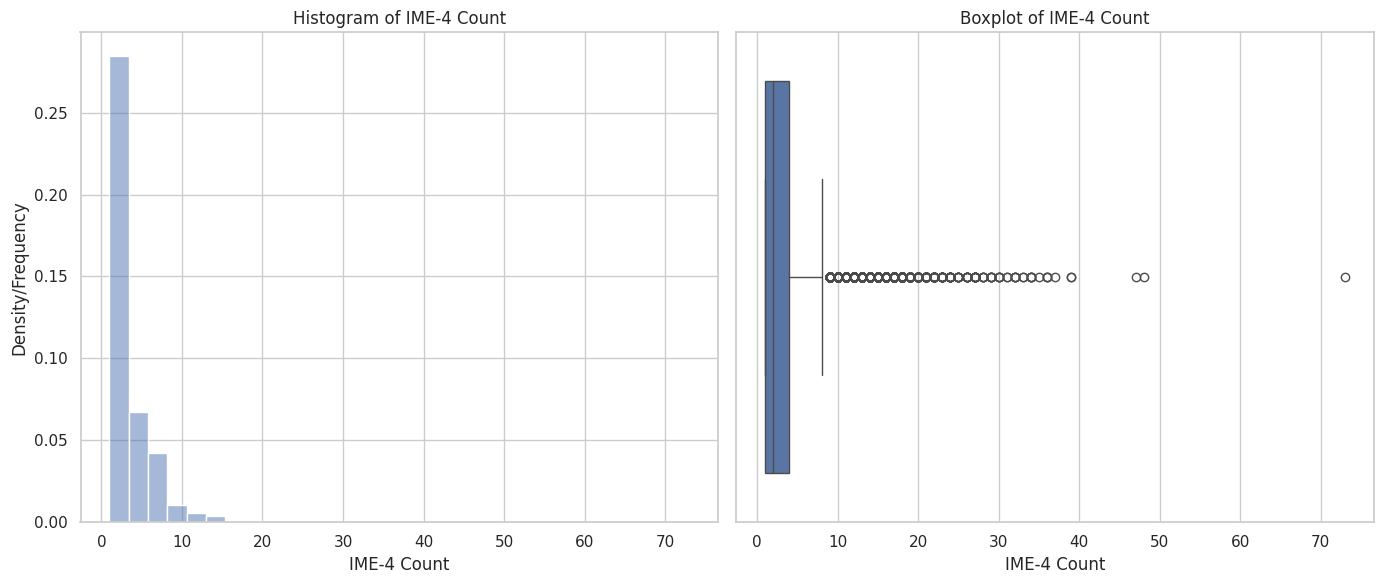

In [95]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Create a histogram for 'IME-4 Count'
sns.histplot(df_train['IME-4 Count'], bins=30, ax=axs[0], stat='density', alpha=0.5)
axs[0].set_title('Histogram of IME-4 Count')
axs[0].set_xlabel('IME-4 Count')
axs[0].set_ylabel('Density/Frequency')

# Create a boxplot for 'IME-4 Count'
sns.boxplot(x=df_train['IME-4 Count'], ax=axs[1],)
axs[1].set_title('Boxplot of IME-4 Count')
axs[1].set_xlabel('IME-4 Count')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

Having more than 10 filled IME-4 forms per claim does raise some concerns and could indicate potential errors or unusual circumstances.

In [96]:
df_train[df_train['IME-4 Count'] > 10]['IME-4 Count'].count()

3794

In [97]:
high_submission_claims = df_train[df_train['IME-4 Count'] > 10]
high_submission_claims.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
269,2019-12-22,22.0,False,2020-01-02,True,443.40,1997.0,2020-01-02,NaT,AMERICAN ZURICH INSURANCE CO,...,74.0,"FELLOW WORKER, PATIENT OR OTHER PERSON",16.0,DISLOCATION,53.0,KNEE,11210,1.0,Not Work Related,2.0
441,2019-12-10,49.0,False,2020-01-02,True,909.39,1970.0,2020-05-29,2019-12-23,EVEREST NATIONAL INSURANCE CO.,...,45.0,COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE,52.0,STRAIN OR TEAR,90.0,MULTIPLE BODY PARTS (INCLUDING BODY,11208,0.0,Not Work Related,1.0
452,2019-12-20,50.0,False,2020-01-02,True,1383.50,0.0,2020-01-02,NaT,MANUFACTURERS ALLIANCE,...,56.0,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,12419,1.0,Not Work Related,0.0
460,2019-12-31,56.0,False,2020-01-02,True,900.20,1964.0,2020-01-02,NaT,STATE INSURANCE FUND,...,29.0,ON SAME LEVEL,28.0,FRACTURE,55.0,ANKLE,12458,0.0,Not Work Related,1.0
741,2019-12-20,39.0,False,2020-01-03,True,756.78,1980.0,2020-01-03,2020-01-24,HARTFORD ACCIDENT & INDEMNITY,...,45.0,COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,10460,0.0,Not Work Related,3.0


Appears that:


*   Alternative Dispute Resolution: The mayjor of the claims have a value of False for the Alternative Dispute Resolution field. This indicates that none of these claims have utilized any alternative methods to resolve the disputes. This might suggest a tendency towards litigation or other formal processes rather than reaching settlements or agreements outside the courtroom.
*   Attorney Representation: The mayjor of the claims have True in the Attorney/Representative field, indicating that all individuals involved in these cases have legal representation. This may suggest that the complexity or severity of these cases warranted the involvement of attorneys.


In [98]:
adr_counts = high_submission_claims['Alternative Dispute Resolution'].value_counts().rename_axis('ADR').reset_index(name='ADR Count')

attorney_counts = high_submission_claims['Attorney/Representative'].value_counts().rename_axis('Attorney').reset_index(name='Attorney Count')

result_df = pd.merge(adr_counts, attorney_counts, left_on='ADR', right_on='Attorney', how='outer')

result_df

,ADR,ADR Count,Attorney,Attorney Count
0,False,3794,False,22
1,<NA>,<NA>,True,3772




*   The absence of ADR in the majority of cases coupled with the high percentage of cases with attorney representation suggests that these cases may involve intricate legal matters that require formal adjudication rather than informal resolution methods.
*   This could indicate a trend where claimants opt for legal counsel to ensure their interests are adequately represented, especially when they perceive the claims to be more complicated or when the potential outcomes carry significant implications.
*   The overall situation might reflect a judicial landscape where claimants feel the need to prepare thoroughly for potential litigation rather than resolving disputes outside the courtroom.
*   In conclusion, while the numbers don't necessarily indicate errors, they do highlight a pattern of complexity in the cases being analyzed, warranting further investigation into the nature and outcomes of these claims.





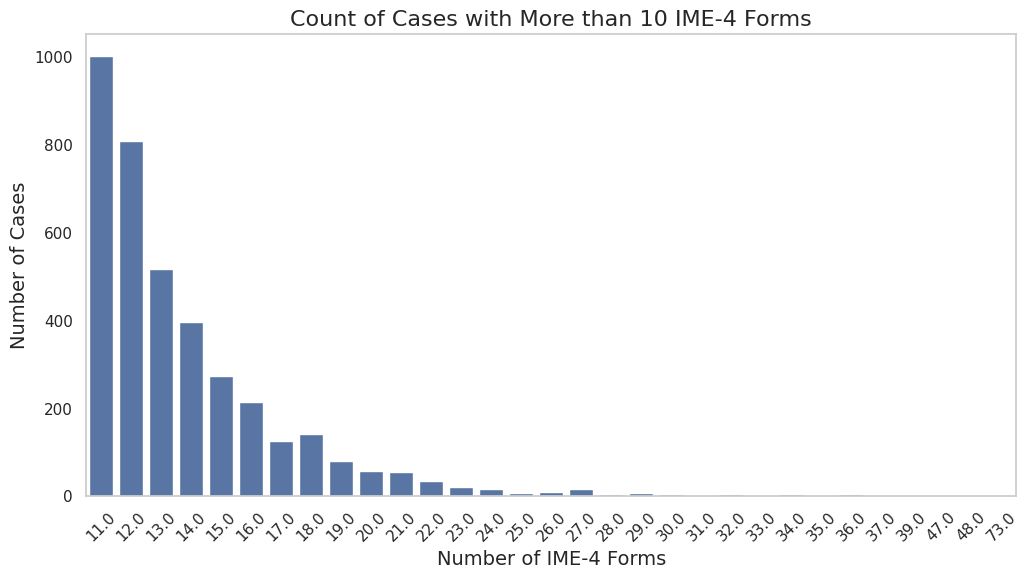

In [99]:
# Filter only the cases with more than 10 IME-4 forms
high_ime4_cases = df_train[df_train['IME-4 Count'] > 10]

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.countplot(data=high_ime4_cases, x='IME-4 Count')

# Set up the plot labels
plt.title('Count of Cases with More than 10 IME-4 Forms', fontsize=16)
plt.xlabel('Number of IME-4 Forms', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()

### Number of Dependents variable

In [100]:
df_train['Number of Dependents'].describe()

,Number of Dependents
count,574021.000000
mean,3.006549
std,2.000797
min,0.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,6.000000


In [101]:
(df_train['Number of Dependents'].isna().mean())*100

3.2765145770777098

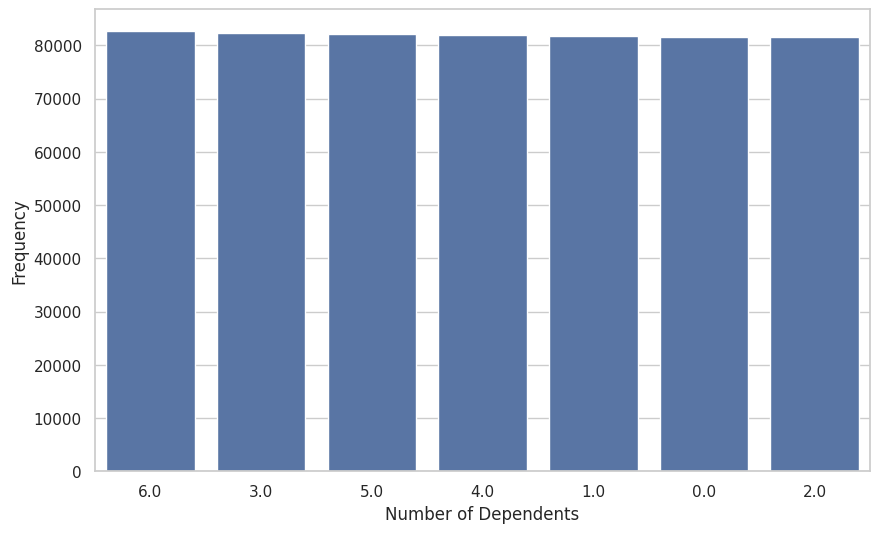

In [102]:
plot_bar(df_train, 'Number of Dependents')

### COVID-19 Indicator variable

In [103]:
df_train['COVID-19 Indicator'].describe()

,COVID-19 Indicator
count,574021
unique,2
top,N
freq,546500


In [104]:
df_train['COVID-19 Indicator'].value_counts()

,count
COVID-19 Indicator,
N,546500
Y,27521


In [105]:
df_train['COVID-19 Indicator'].isna().sum()

19445

In [106]:
df_train['COVID-19 Indicator'] = df_train['COVID-19 Indicator'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_train['COVID-19 Indicator'] = df_train['COVID-19 Indicator'].astype("boolean")

df_test['COVID-19 Indicator'] = df_test['COVID-19 Indicator'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_test['COVID-19 Indicator'] = df_test['COVID-19 Indicator'].astype("boolean")

<ipython-input-106-46c2de5b6eeb>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['COVID-19 Indicator'] = df_test['COVID-19 Indicator'].replace({'Y': True, 'N': False})


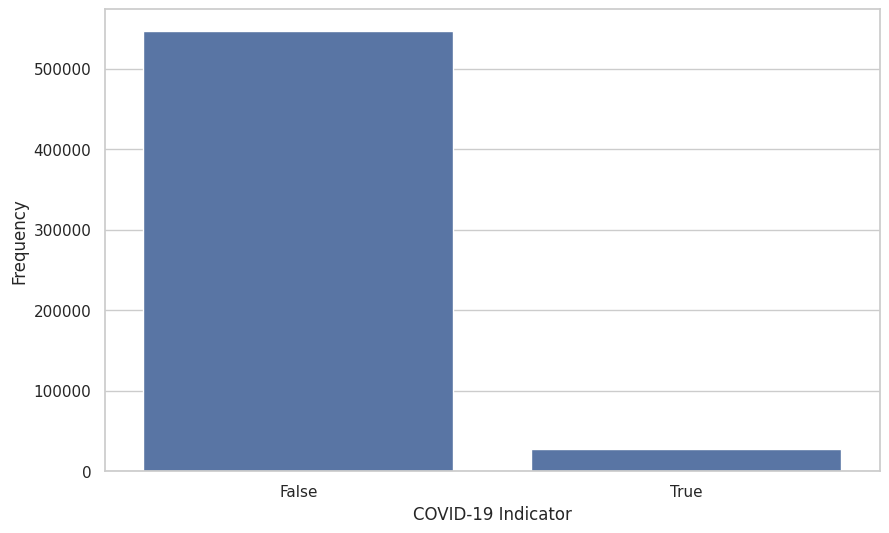

In [107]:
plot_bar(df_train, 'COVID-19 Indicator')

### Average Weekly Wage variable

In [108]:
df_train['Average Weekly Wage'].describe()

,Average Weekly Wage
count,5.453710e+05
mean,4.910919e+02
std,6.092940e+03
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,8.410000e+02
max,2.828079e+06


In [109]:
(df_train['Average Weekly Wage'] == 0).sum()

335446

It is not possible to have values in 'Average Weekly Wage' recorded as zero since we are talking about workers. Since there are 333933 values recorded as zero, it is very unlikely that this is an error. We should replace the zeros with NaN values.

In [110]:
df_train['Average Weekly Wage'] = df_train['Average Weekly Wage'].replace(0, np.nan)

In [111]:
(df_train['Average Weekly Wage'].isna().mean())*100


64.62729120118085

More than 60% of the Average Weekly Wage column has unknown information. This gonna produce issues in analysis and modeling. Replacing those missing values with statistical measures like the mean or median can skew results and introduce bias, especially if the data is not missing at random. Using methods like KNN can also lead to unreliable estimates if the underlying distribution is not well understood.


Given these circumstances, removing the column might be the most prudent approach.


Let's explore the variable anyway

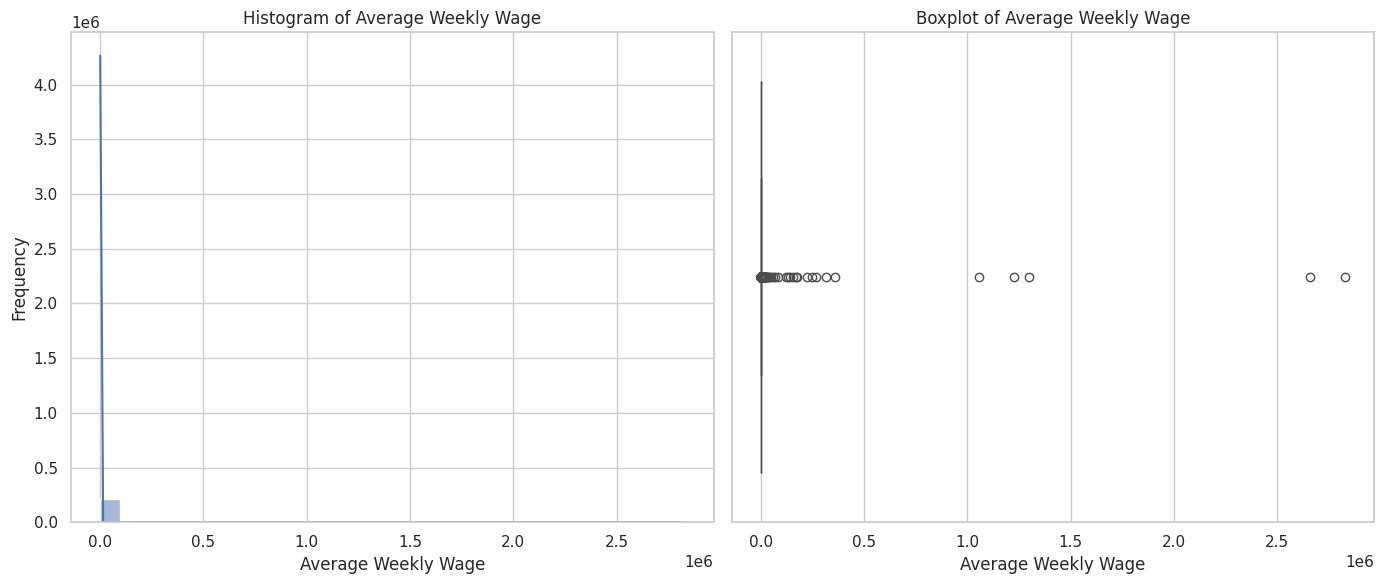

In [112]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df_train['Average Weekly Wage'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Histogram of Average Weekly Wage')
axs[0].set_xlabel('Average Weekly Wage')
axs[0].set_ylabel('Frequency')

sns.boxplot(x=df_train['Average Weekly Wage'], ax=axs[1])
axs[1].set_title('Boxplot of Average Weekly Wage')
axs[1].set_xlabel('Average Weekly Wage')

plt.tight_layout()
plt.show()

### Industry code and Industry code description variable

In [175]:
df_train['Industry Code'].describe()

,Industry Code
count,559252.0
unique,24.0
top,62.0
freq,113830.0


In [178]:
df_train['Industry Code'].value_counts()

,count
Industry Code,
62.0,113830
92.0,91800
61.0,44207
44.0,43324
48.0,36474
23.0,30418
72.0,26259
56.0,20734
45.0,17830


In [177]:
(df_train['Industry Code'].isna().mean())*100

1.4914068403558804

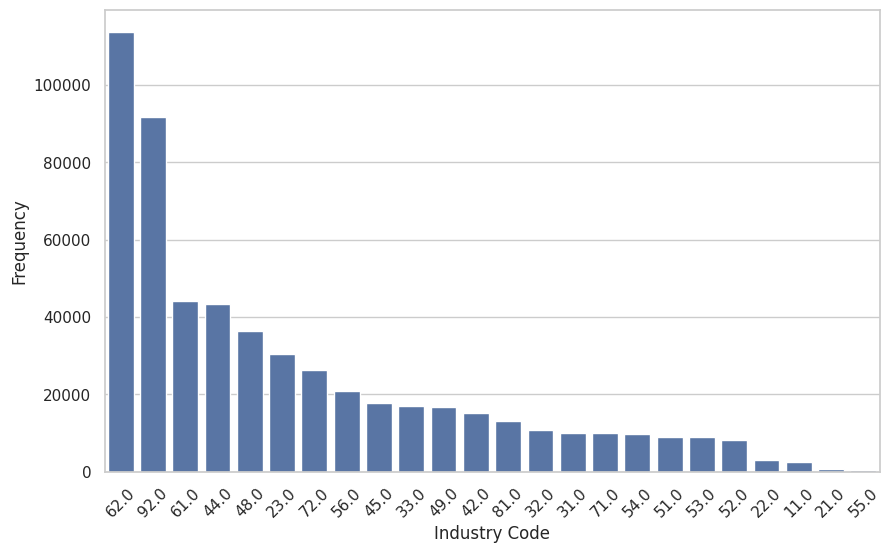

In [181]:
plot_bar(df_train, 'Industry Code',degrees=45)

Only missing values, no problems found.

### Medical Fee Region variable

In [182]:
df_train['Medical Fee Region'].describe()

,Medical Fee Region
count,567719
unique,5
top,IV
freq,262904


In [183]:
df_train['Medical Fee Region'].value_counts()

,count
Medical Fee Region,
IV,262904
I,134652
II,84261
III,53055
UK,32847


In [186]:
(df_train['Medical Fee Region'].isna().mean())*100

0.0

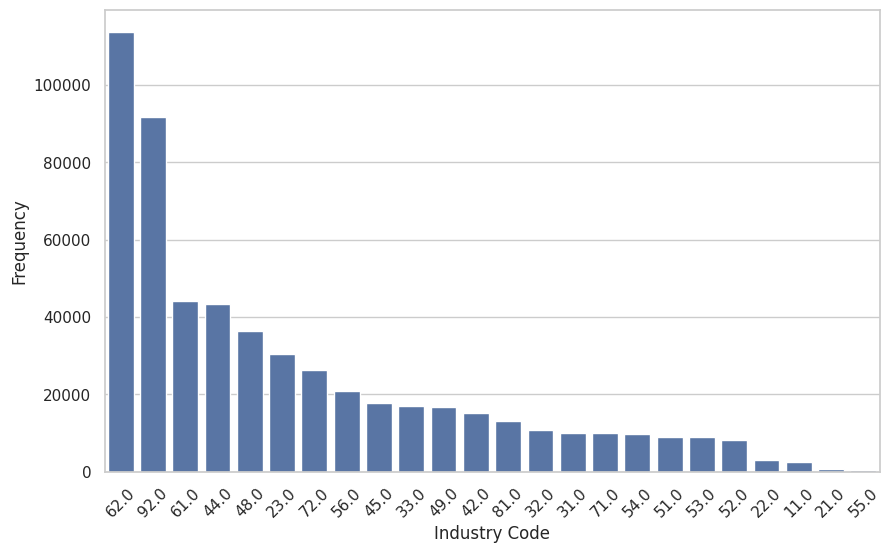

In [188]:
plot_bar(df_train, 'Industry Code',degrees=45)

Only missing values, no problems found.

### WCIO Cause of Injury Code and WCIO Cause of Injury Description variables

In [189]:
df_train['WCIO Cause of Injury Code'].describe()

,WCIO Cause of Injury Code
count,554622.0
unique,77.0
top,56.0
freq,46458.0


In [191]:
df_train['WCIO Cause of Injury Description'].describe()

,WCIO Cause of Injury Description
count,554622
unique,74
top,LIFTING
freq,46458


In [192]:
df_train['WCIO Cause of Injury Code'].value_counts()

,count
WCIO Cause of Injury Code,
56.0,46458
74.0,37077
60.0,32972
31.0,31569
29.0,29201
...,...
91.0,55
14.0,51
40.0,45


In [193]:
df_train['WCIO Cause of Injury Description'].value_counts()

,count
WCIO Cause of Injury Description,
LIFTING,46458
"FELLOW WORKER, PATIENT OR OTHER PERSON",37077
"STRAIN OR INJURY BY, NOC",32972
"FALL, SLIP OR TRIP, NOC",31569
ON SAME LEVEL,29201
...,...
MOLD,55
ABNORMAL AIR PRESSURE,51
CRASH OF WATER VEHICLE,45


In [197]:
(df_train['WCIO Cause of Injury Code'].isna().mean())*100

2.306951150128849

In [196]:
(df_train['WCIO Cause of Injury Description'].isna().mean())*100

2.306951150128849

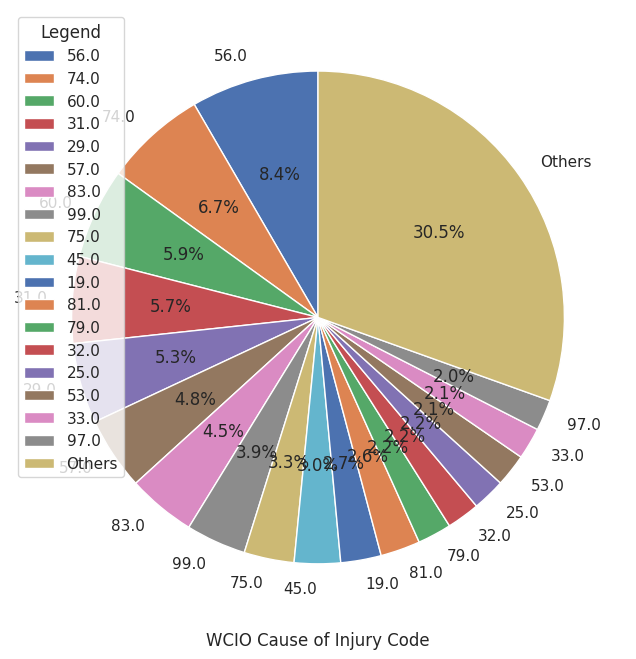

In [200]:
plot_pie(df_train, 'WCIO Cause of Injury Code')

### WCIO Part of Body Code and WCIO Part of Body Description variables

In [203]:
df_train.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Accident Year', 'Accident Month', 'Accident DayOfWeek'],
      dtype='object')

In [204]:
df_train['WCIO Part Of Body Code'].describe()

,WCIO Part Of Body Code
count,553581.0
unique,57.0
top,42.0
freq,51662.0


In [205]:
df_train['WCIO Part Of Body Description'].describe()

,WCIO Part Of Body Description
count,553581
unique,54
top,LOWER BACK AREA
freq,51662


In [206]:
df_train['WCIO Part Of Body Code'].value_counts()

,count
WCIO Part Of Body Code,
42.0,51662
53.0,47740
-9.0,41788
38.0,37647
36.0,36021
35.0,31176
55.0,24897
90.0,22381
56.0,18716


In [207]:
df_train['WCIO Part Of Body Description'].value_counts()

,count
WCIO Part Of Body Description,
LOWER BACK AREA,51662
KNEE,47740
MULTIPLE,41788
SHOULDER(S),37647
FINGER(S),36021
HAND,31176
ANKLE,24897
MULTIPLE BODY PARTS (INCLUDING BODY,22381
SOFT TISSUE,19607


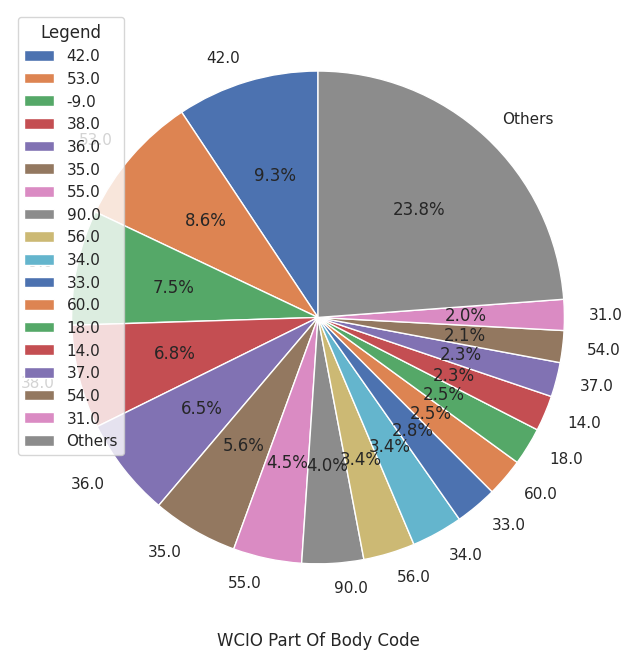

In [208]:
plot_pie(df_train, 'WCIO Part Of Body Code')

Minus code for "-9.0", change to 9.0.

In [209]:
# Temporarily convert to numeric to apply absolute value, then convert back to category
df_train["WCIO Part Of Body Code"] = pd.to_numeric(df_train["WCIO Part Of Body Code"], errors='coerce').abs().astype('category')
df_test["WCIO Part Of Body Code"] = pd.to_numeric(df_test["WCIO Part Of Body Code"], errors='coerce').abs().astype('category')

print("Converted all 'WCIO Part Of Body Code' values to positive and restored as categorical.")

Converted all 'WCIO Part Of Body Code' values to positive and restored as categorical.


### ZIP Code variable

In [210]:
df_train['Zip Code'].describe()

,Zip Code
count,539398
unique,9992
top,11236
freq,3273


In [211]:
df_train['Zip Code'].value_counts()

,count
Zip Code,
11236,3273
10940,2952
11717,2775
11434,2721
11706,2685
...,...
17813,1
37139,1
85204,1


In [213]:
(df_train['Zip Code'].isna().mean())*100

4.988559481010852

In [218]:
zip_code_counts = df_train.copy()

In [220]:
zip_code_temp = df_train["Zip Code"].dropna().astype(str)

1. Check for Negative Values

In [221]:
negative_values = zip_code_temp[zip_code_temp.str.startswith('-')]
if not negative_values.empty:
    print("Negative values found in 'Zip Code':")
    display(negative_values)

2. Check for Non-Numeric Characters


In [222]:
non_numeric = zip_code_temp[~zip_code_temp.str.match(r'^\d+$')]
if not non_numeric.empty:
    print("Non-numeric values found in 'Zip Code':")
    display(non_numeric)

Non-numeric values found in 'Zip Code':


,Zip Code
4585,L1N 5
9359,T1B0P
9751,L6Y 1
13688,JMDMR
15048,N2P 1
...,...
576577,V1M2B
580232,L2P0A
581907,L6L 1
583384,L1A 1


3. Check for Length Inconsistencies (assuming standard 5 digits)

In [223]:
length_inconsistent = zip_code_temp[zip_code_temp.str.len() != 5]
if not length_inconsistent.empty:
    print("Inconsistent length values found in 'Zip Code':")
    display(length_inconsistent)

Inconsistent length values found in 'Zip Code':


,Zip Code
41789,T2V
111214,SLV
182452,L9W
228112,P7G
262144,10567.0
...,...
420949,K9J
429765,M5R
455762,L1G
478123,J5K


4. Check for Placeholder Values (any amount of zeros, e.g., '000', '00000')

In [224]:
placeholders = zip_code_temp[zip_code_temp.str.match(r'^0+$')]
if not placeholders.empty:
    print("Placeholder values found in 'Zip Code' (any amount of zeros):")
    display(placeholders)

Placeholder values found in 'Zip Code' (any amount of zeros):


,Zip Code
44780,00000
48863,00000
73168,00000
77384,00000
215545,00000
324129,00000
329697,00000
527010,00000
527275,00000
540776,00000


Fill placeholders as NaNs.

In [225]:
# Replace placeholder values with NaN in the original DataFrame
df_train.loc[df_train["Zip Code"].str.match(r'^0+$', na=False), "Zip Code"] = np.nan
print("Replaced placeholder values with NaN in 'Zip Code'.")

Replaced placeholder values with NaN in 'Zip Code'.


### Claim Injury Type variable

In [226]:
df_train['Claim Injury Type'].describe()

,Claim Injury Type
count,567719
unique,8
top,2. NON-COMP
freq,287676


In [227]:
df_train['Claim Injury Type'].value_counts()

,count
Claim Injury Type,
2. NON-COMP,287676
4. TEMPORARY,147772
3. MED ONLY,68577
5. PPD SCH LOSS,48222
1. CANCELLED,10722
6. PPD NSL,4201
8. DEATH,452
7. PTD,97


In [228]:
(df_train['Claim Injury Type'].isna().mean())*100

0.0

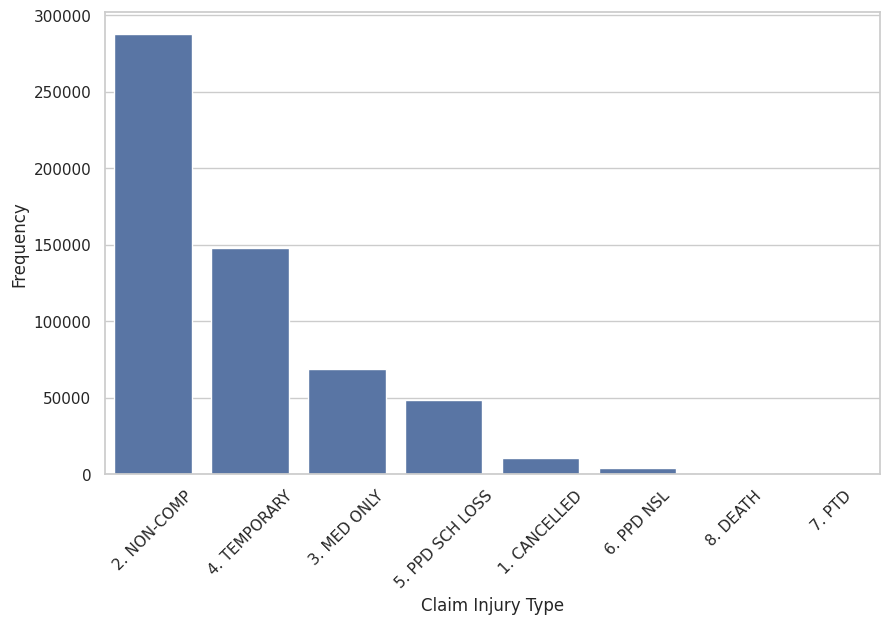

In [230]:
plot_bar(df_train, 'Claim Injury Type',degrees=45)

### Gender variable

In [231]:
df_train['Gender'].describe()

,Gender
count,567719
unique,4
top,M
freq,330967


In [232]:
df_train['Gender'].value_counts()

,count
Gender,
M,330967
F,232066
U,4641
X,45


In [233]:
(df_train['Gender'].isna().mean())*100

0.0

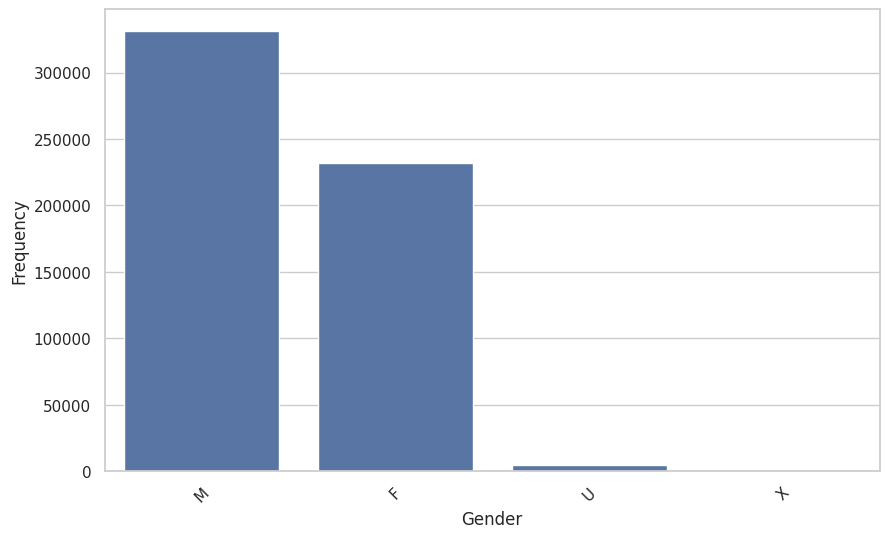

In [234]:
plot_bar(df_train, 'Gender',degrees=45)

Only missing values, no problems found.

In [113]:
# For each column
    # Descriptive stats
    # Visualization (Bar, hist, boxplot, .., whatever makes sense)
        # Use above helper function
    # Problems (missing values, invalid values etc.)
        # show examples etc.
    # how to deal with the problems
        # remove rows? replace with null? what happens to null values (replace with median, knN, mode etc)?
        # analyse and find solution with train -> apply solution to train and test

In [114]:
# Empty columns: WCB Decision (in test), OIICS Nature of Injury Description, Agreement Reached
    # Ignore those

In [115]:
# Daniel:
"""
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64
 3   Assembly Date                       593471 non-null  datetime64[ns]
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 16  First Hearing Date                  150798 non-null  datetime64[ns]
 2   Alternative Dispute Resolution      574026 non-null  object
 4   Attorney/Representative             574026 non-null  object
 10  Carrier Type                        574026 non-null  object
 13  County of Injury                    574026 non-null  object
 """

'\n 0   Accident Date                       570337 non-null  datetime64[ns]\n 1   Age at Injury                       574026 non-null  float64\n 3   Assembly Date                       593471 non-null  datetime64[ns]\n 6   Birth Year                          544948 non-null  float64\n 7   C-2 Date                            559466 non-null  datetime64[ns]\n 8   C-3 Date                            187245 non-null  datetime64[ns]\n 16  First Hearing Date                  150798 non-null  datetime64[ns]\n 2   Alternative Dispute Resolution      574026 non-null  object\n 4   Attorney/Representative             574026 non-null  object\n 10  Carrier Type                        574026 non-null  object\n 13  County of Injury                    574026 non-null  object\n '

In [116]:
# Louis:
"""
 19  Industry Code                       564068 non-null  float64
 20  Industry Code Description           564068 non-null  object
 21  Medical Fee Region                  574026 non-null  object
 23  WCIO Cause of Injury Code           558386 non-null  float64
 24  WCIO Cause of Injury Description    558386 non-null  object
 25  WCIO Nature of Injury Code          558369 non-null  float64
 26  WCIO Nature of Injury Description   558369 non-null  object
 27  WCIO Part Of Body Code              556944 non-null  float64
 28  WCIO Part Of Body Description       556944 non-null  object
 29  Zip Code                            545389 non-null  object
 12  Claim Injury Type                   574026 non-null  object
 17  Gender                              574026 non-null  object
"""

'\n 19  Industry Code                       564068 non-null  float64\n 20  Industry Code Description           564068 non-null  object\n 21  Medical Fee Region                  574026 non-null  object\n 23  WCIO Cause of Injury Code           558386 non-null  float64\n 24  WCIO Cause of Injury Description    558386 non-null  object\n 25  WCIO Nature of Injury Code          558369 non-null  float64\n 26  WCIO Nature of Injury Description   558369 non-null  object\n 27  WCIO Part Of Body Code              556944 non-null  float64\n 28  WCIO Part Of Body Description       556944 non-null  object\n 29  Zip Code                            545389 non-null  object\n 12  Claim Injury Type                   574026 non-null  object\n 17  Gender                              574026 non-null  object\n'

In [117]:
# Rita:
"""
 5   Average Weekly Wage                 545375 non-null  float64
 9   Carrier Name                        574026 non-null  object
 11  Claim Identifier                    593471 non-null  int64
 14  COVID-19 Indicator                  574026 non-null  object
 15  District Name                       574026 non-null  object
 18  IME-4 Count                         132803 non-null  float64
 22  Number of Dependents                574026 non-null  float64
"""

'\n 5   Average Weekly Wage                 545375 non-null  float64\n 9   Carrier Name                        574026 non-null  object\n 11  Claim Identifier                    593471 non-null  int64\n 14  COVID-19 Indicator                  574026 non-null  object\n 15  District Name                       574026 non-null  object\n 18  IME-4 Count                         132803 non-null  float64\n 22  Number of Dependents                574026 non-null  float64\n'

## Step 3: Cross-Feature analysis

In [118]:
# cross-feature inconsistencies
    # all dates have to be after incident date
    # if covid code -> covid has to be true
    # code vs description (just check, we will ignore the descriptions later)
    # How to deal with inconsistencies
# cross-feature visualisations
    # Write down Visualisation insights

# Re-Run of Exploratory Analysis